# Lecture 3: Train/Test and Cross-Validation

In this notebook, we'll see how to create train/test splits in python.  We'll also see the `GridSearchCV` function, which is a very simple way to do cross-validation to select tuneable parameters.

In [1]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier # Import k-nearest neighbors
from sklearn.metrics import roc_curve, roc_auc_score # Import functions to measure classification error
from sklearn.cross_validation import train_test_split # Import functionality to implement the validation set approach
from sklearn.grid_search import GridSearchCV # Import GridSearchCV, for cross-validation
import numpy as np
import pandas as pd

Let's read in the "Hitters" dataset from ISLR that has information on baseball players, their stats, and their salaries.  Also, we'll drop any rows with missing values.

In [10]:
hitters = pd.read_csv("./hitters.csv")
hitters = hitters.dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We'll get rid of a few categorical columns rather than deal with converting them.  Then we'll create a binary variable for whether a player makes more than the median salary.

In [4]:
X = np.array(hitters.drop(["Salary", "League", "Division", "NewLeague"], axis=1))
y = (hitters["Salary"] >= np.median(hitters["Salary"])).astype("int")

# The Validation Set Approach
Creating a training/testing split is extremely simple.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=10)

In [6]:
print X_train.shape
print X_test.shape

(184L, 16L)
(79L, 16L)


In [7]:
X_train

array([[496, 119,   8, ..., 155, 371,  29],
       [317,  78,   7, ...,  45, 122,  26],
       [343, 103,   6, ..., 211,  56,  13],
       ..., 
       [616, 163,  27, ..., 110, 308,  15],
       [190,  46,   2, ..., 102, 177,  16],
       [165,  39,   2, ..., 332,  19,   2]], dtype=int64)

Next, we'll fit a logistic regression model to the training data and score the test data:

In [14]:
kNN = KNeighborsClassifier(n_neighbors=6) # Construct the nearest neighbors classifier, with 3 neighbors
kNN.fit(X_train, y_train) # Fit the nearest neighbors classifier on the training data

test_preds = kNN.predict_proba(X_test)[:, 1] # Predict on the test set, outputting probability of salary > median

Next, let's create the ROC curve.

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)

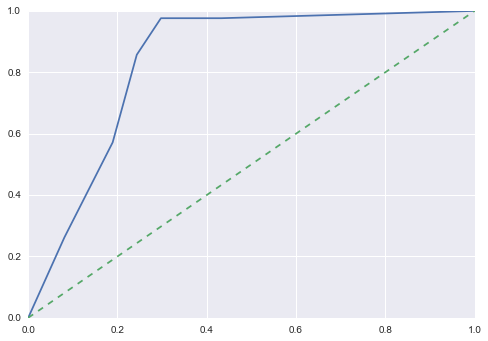

In [16]:
# we want to draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

plt.plot(fpr, tpr)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [17]:
roc_auc_score(y_test, test_preds)

0.83655083655083662

If we re-run the train/test split, we'll see the variability in this estimate.

We can use the test set (which, in this case, should really be called a validation set) to choose the best value of $k$, the number of neighbors in our k-nearest neighbors model.

In [18]:
# We will create a k-nearest neighbors classifier for k=1,2,...,15
# We'll fit each classifier on the training set, then calculate
# out-of-sample AUC on the validation set.
k_vals = np.linspace(1,15,15)

aucs = []
for k_val in k_vals:
    kNN = KNeighborsClassifier(n_neighbors=k_val)
    kNN.fit(X_train, y_train)

    test_preds = kNN.predict_proba(X_test)[:, 1] # Retrieve just the probability of salary > median
    aucs.append(roc_auc_score(y_test, test_preds)) # Store the AUC for the current classifier

C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


In [19]:
# Look at the AUC's
aucs

[0.806949806949807,
 0.86261261261261257,
 0.87612612612612617,
 0.86872586872586866,
 0.84716859716859716,
 0.83655083655083662,
 0.83912483912483926,
 0.8285070785070785,
 0.82722007722007729,
 0.82818532818532831,
 0.82593307593307608,
 0.82915057915057921,
 0.83172458172458175,
 0.83815958815958824,
 0.83043758043758042]

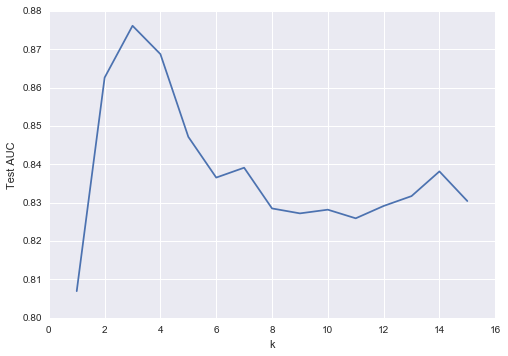

In [20]:
# Plot the auc's against our measure of flexibility, $k$
plt.plot(k_vals, aucs)
plt.xlabel("k")
plt.ylabel("Test AUC")
plt.show()

We see that the test AUC is maximized at $k=3$ for this specific train/validate split.

# Cross-Validation

Instead of using a train/test split, scikit-learn has a really nice way to use cross-validation to choose the tuneable parameters of a model.  First, we make a dictionary, where the key is the name of the parameter we want to tune (it has to match the name of the parameter in the model), and the values are the values we want to try:

In [22]:
k_vals = np.linspace(1,30,30)
param_grid = {"n_neighbors": k_vals}

Then, we pass in the model we want to fit and the grid.  The option 'n_jobs' allows us to split the cross-validation over multiple cores of your computer, and `refit` tells it to fit the best performing model on the full dataset once it's done.

In [23]:
cv = GridSearchCV(kNN, param_grid, cv=10, n_jobs=4, refit=True, verbose=True)
cv.fit(X_train, y_train) # Notice that we're doing cross-validation within our training set.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.4min finished


Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15.0, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_neighbors': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

We can see the best values and the grid scores:

In [24]:
cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14.0, p=2,
           weights='uniform')

In [25]:
cv.best_params_

{'n_neighbors': 14.0}

In [26]:
cv.best_score_

0.8532608695652174

In [27]:
cv.grid_scores_

[mean: 0.73913, std: 0.12913, params: {'n_neighbors': 1.0},
 mean: 0.71196, std: 0.12369, params: {'n_neighbors': 2.0},
 mean: 0.78261, std: 0.08736, params: {'n_neighbors': 3.0},
 mean: 0.75543, std: 0.09676, params: {'n_neighbors': 4.0},
 mean: 0.79348, std: 0.05434, params: {'n_neighbors': 5.0},
 mean: 0.76630, std: 0.08053, params: {'n_neighbors': 6.0},
 mean: 0.80978, std: 0.04142, params: {'n_neighbors': 7.0},
 mean: 0.81522, std: 0.04608, params: {'n_neighbors': 8.0},
 mean: 0.84239, std: 0.05318, params: {'n_neighbors': 9.0},
 mean: 0.83152, std: 0.05794, params: {'n_neighbors': 10.0},
 mean: 0.83696, std: 0.05672, params: {'n_neighbors': 11.0},
 mean: 0.84239, std: 0.05318, params: {'n_neighbors': 12.0},
 mean: 0.84239, std: 0.05318, params: {'n_neighbors': 13.0},
 mean: 0.85326, std: 0.06098, params: {'n_neighbors': 14.0},
 mean: 0.85326, std: 0.06098, params: {'n_neighbors': 15.0},
 mean: 0.84239, std: 0.05870, params: {'n_neighbors': 16.0},
 mean: 0.84783, std: 0.05473, par

In [28]:
cv.grid_scores_[0][1] # Pulls the mean out-of-sample AUC for the first model that was tried (k-nn with n = 1)

0.7391304347826086

In [29]:
cv.grid_scores_[0][2].std() # Pulls the standard deviation of the out-of-sample AUC's for the k=1 nearest neighbor model

0.12913420843383117

Now, let's plot the cross-validation estimates for the test AUC

In [31]:
scores = np.array([x[1] for x in cv.grid_scores_]) # Get the mean out-of-sample AUC for all values of k
std_devs = np.array([x[2].std() for x in cv.grid_scores_]) # Get the standard deviation of the out-of-sample AUC for all values of k

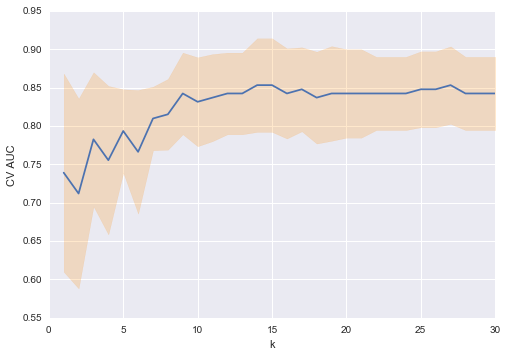

In [32]:
plt.plot(k_vals,scores)
plt.fill_between(k_vals, scores - std_devs,
                 scores + std_devs, alpha=0.2,
                 color="darkorange")
plt.xlabel("k")
plt.ylabel("CV AUC")
plt.show()

We see that the k-nn model with $k=3$ is clearly worse than the less flexible models with larger values of $k$.  Since cross-validation generally gives a better estimate of test error the the validation set approach, we can conclde that the less flexible model with $k=14$ should be used over the model with $k=3$.  This is an example of the bias-variance tradeoff -the more flexible model with $k=3$ does not do as well as the less flexible model with $k=14$.

Next, we take the best model from the cross-validation exercise (which GridSearchCV has already fit on the full dataset for us) and predict on the original validation set.

In [33]:
test_preds = cv.best_estimator_.predict_proba(X_test)[:, 1]
test_preds

array([ 0.        ,  0.64285714,  0.92857143,  0.        ,  0.71428571,
        0.85714286,  0.71428571,  0.92857143,  0.07142857,  0.78571429,
        0.92857143,  0.07142857,  0.5       ,  0.71428571,  0.28571429,
        0.57142857,  0.71428571,  0.07142857,  0.71428571,  0.71428571,
        0.78571429,  0.92857143,  0.64285714,  0.        ,  0.        ,
        0.        ,  0.78571429,  0.        ,  0.5       ,  0.        ,
        0.78571429,  0.78571429,  0.42857143,  0.        ,  0.78571429,
        0.        ,  0.85714286,  0.92857143,  0.85714286,  0.78571429,
        0.        ,  0.85714286,  1.        ,  0.85714286,  0.07142857,
        0.        ,  0.57142857,  0.        ,  0.71428571,  0.78571429,
        1.        ,  0.71428571,  0.85714286,  0.85714286,  0.85714286,
        0.85714286,  0.57142857,  0.85714286,  0.78571429,  0.        ,
        0.71428571,  0.        ,  0.78571429,  0.        ,  0.64285714,
        0.07142857,  0.85714286,  0.71428571,  0.85714286,  0.  

In [34]:
roc_auc_score(y_test, test_preds)

0.83815958815958824